BloomTech Data Science

*Unit 2, Sprint 1, Module 3*

---

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.* # install encoder in Colab environment

# If you're working locally:
else:
    DATA_PATH = '../data/'

# Module Project: Ridge Regression

For this project, you'll return to the Tribecca Condo dataset. But this time, you'll look at the _entire_ dataset and try to predict property sale prices.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.

## Directions

The tasks for this project are the following:

- **Task 1:** Import `csv` file using `wrangle` function.
- **Task 2:** Conduct exploratory data analysis (EDA), and modify `wrangle` function to engineer two subset your dataset to one-family dwellings whose price is between \$100,000 and \$2,000,000.
- **Task 3:** Split data into feature matrix `X` and target vector `y`.
- **Task 4:** Split feature matrix `X` and target vector `y` into training and test sets.
- **Task 5:** Establish the baseline mean absolute error for your dataset.
- **Task 6:** Build and train a `OneHotEncoder`, and transform `X_train` and `X_test`.
- **Task 7:** Build and train a `LinearRegression` model.
- **Task 8:** Build and train a `Ridge` model.
- **Task 9:** Calculate the training and test mean absolute error for your `LinearRegression` model.
- **Task 10:** Calculate the training and test mean absolute error for your `Ridge` model.
- **Task 11:** Create a horizontal bar chart showing the 10 most influencial features for your `Ridge` model. 

**Note**

You should limit yourself to the following libraries for this project:

- `category_encoders`
- `matplotlib`
- `pandas`
- `sklearn`

In [2]:
# Import libraries
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error # to assess model performance

from category_encoders import OneHotEncoder

# I. Wrangle Data

In [32]:
def wrangle(filepath):

    # Import csv file                     
    cols = ['BOROUGH', 'NEIGHBORHOOD',
            'BUILDING CLASS CATEGORY', 'GROSS SQUARE FEET',  
            'YEAR BUILT', 'SALE PRICE', 'SALE DATE']
    df = pd.read_csv(filepath, 
                     usecols=cols, 
                     parse_dates=['SALE DATE'], # Transform sale date into Datetime
                     index_col= 'SALE DATE', # Set sale date as index
                     dtype={'BOROUGH':'object'}) # Change the BOROUGH column data type from int to obj
    
    # Clean column headers
    df.columns = df.columns.str.lower().str.replace(' ', '_')


    # Transform sale_price data type from obj to int
    df['sale_price'] = (df['sale_price'].str.split().str[-1].str.replace(',','')).astype(int)

    # Subset df to one-fam dwellings  between 100k-2million
    df = df[(df['building_class_category'] == '01 ONE FAMILY DWELLINGS')
          & (df['sale_price'] > 100_000)
             & (df['sale_price'] < 2_000_000)]

    return df.drop(columns='building_class_category')

filepath = DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv'

**Task 1:** Use the above `wrangle` function to import the `NYC_Citywide_Rolling_Calendar_Sales.csv` file into a DataFrame named `df`.

In [33]:
df = wrangle(filepath)

**Task 2:** Modify the above `wrangle` function so that:

- The column `'SALE DATE'` becomes the `DatetimeIndex`.
- The dtype for the `'BOROUGH'` column is `object`, not `int`.
- The dtype for the `'SALE PRICE'` column is `int`, not `object`.
- The dataset includes only one-family dwellings (`BUILDING CLASS CATEGORY == '01 ONE FAMILY DWELLINGS'`).
- The dataset includes only properties whose sale price is between \$100,000 and \$2,000,000.

In [34]:
# Perform your exploratory data analysis here and
# modify the wrangle function above

# Get the first rows and the shape of the dataset
print(df.shape)
df.head()

(3151, 5)


,borough,neighborhood,gross_square_feet,year_built,sale_price
SALE DATE,,,,,
2019-01-01,3,OCEAN PARKWAY-NORTH,1325.0,1930.0,550000
2019-01-01,4,QUEENS VILLAGE,2001.0,1940.0,200000
2019-01-02,2,PELHAM PARKWAY SOUTH,2043.0,1925.0,810000
2019-01-02,3,FLATBUSH-CENTRAL,2680.0,1899.0,125000
2019-01-02,3,FLATBUSH-EAST,1872.0,1940.0,620000


In [35]:
# Get the last rows of the data set
df.tail()

,borough,neighborhood,gross_square_feet,year_built,sale_price
SALE DATE,,,,,
2019-04-30,4,ROSEDALE,1478.0,1925.0,635000
2019-04-30,4,SOUTH OZONE PARK,1280.0,1930.0,514000
2019-04-30,4,SOUTH OZONE PARK,1333.0,1945.0,635000
2019-04-30,4,SPRINGFIELD GARDENS,1020.0,1935.0,545000
2019-04-30,4,ST. ALBANS,1224.0,1945.0,510000


In [37]:
# Check data types for each individual column
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3151 entries, 2019-01-01 to 2019-04-30
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   borough            3151 non-null   object 
 1   neighborhood       3151 non-null   object 
 2   gross_square_feet  3151 non-null   float64
 3   year_built         3151 non-null   float64
 4   sale_price         3151 non-null   int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 147.7+ KB


In [38]:
# Check for null values
df.isnull().sum()

borough              0
neighborhood         0
gross_square_feet    0
year_built           0
sale_price           0
dtype: int64

In [9]:
# Process to convert 'sale_price' into an int
# df['sale_price'] = (df['sale_price'].str.split().str[-1].str.replace(',','')).astype(int)

# Alternative way
# df['sale_price'] = (
#     df['sale_price']
#     .str.replace('$', '')
#     .str.replace('_', '')
#     .str.replace(',', '')
#     .astype(int))


In [10]:
# Filter dataset to only include BUILDING CLASS CATEGORY == '01 ONE FAMILY DWELLINGS'
# and properties which sale price is between $100,000 and $2,000,000
# df.loc[(df['BUILDING CLASS CATEGORY'] == '01 ONE FAMILY DWELLINGS') & (df['SALE PRICE'] < 2000000) & (df['SALE PRICE'] > 100000)]


In [39]:
# Check min and max sale price after subsetting our data
df['sale_price'].min(), df['sale_price'].max()

(104000, 1955000)

# II. Split Data

**Task 3:** Split your dataset into the feature matrix `X` and the target vector `y`. You want to predict `'SALE_PRICE'`.

In [12]:
target = 'sale_price'
X = df.drop(columns=target) # feature matrix
y = df[target] # vector

In [40]:
# Check shape
X.shape, y.shape

((3151, 4), (3151,))

In [41]:
# Print the head of the vector y
y.head()

SALE DATE
2019-01-01    550000
2019-01-01    200000
2019-01-02    810000
2019-01-02    125000
2019-01-02    620000
Name: sale_price, dtype: int64

**Task 4:** Split `X` and `y` into a training set (`X_train`, `y_train`) and a test set (`X_test`, `y_test`).

- Your training set should include data from January to March 2019. 
- Your test set should include data from April 2019.

In [42]:
# Set cutoff
cutoff = '2019-04-01'

# Create a mask
mask = X.index < cutoff

# Apply the mask to the training set and invert the mask for the test set
X_train, y_train = X.loc[mask], y.loc[mask]
X_test, y_test = X.loc[~mask], y.loc[~mask]

In [16]:
# Check training set shape to ensure the split was appropriately done
X_train.shape, y_train.shape

((2507, 4), (2507,))

In [43]:
# Check test set shape
X_test.shape, y_test.shape

((644, 4), (644,))

In [44]:
# Verification
assert len(X_train) + len(X_test) == len(X)

# III. Establish Baseline

**Task 5:** Since this is a **regression** problem, you need to calculate the baseline mean absolute error for your model.

In [19]:
y_pred = [y_train.mean()]*len(y_train)
baseline_mae = mean_absolute_error(y_train, y_pred)
print('Mean Sale Price:', y_train.mean())
print('Baseline MAE:', baseline_mae)

Mean Sale Price: 621573.7423214999
Baseline MAE: 214721.52773001452


**Insights:** If we always predicted the sale price to be on average \$621,574, we would be off by about \$214,722.

# IV. Build Model 

**Task 6:** Build and train a `OneHotEncoder` and then use it to transform `X_train` and `X_test`.

In [20]:
# Check data types of X_train
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2507 entries, 2019-01-01 to 2019-03-30
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   borough            2507 non-null   object 
 1   neighborhood       2507 non-null   object 
 2   gross_square_feet  2507 non-null   float64
 3   year_built         2507 non-null   float64
dtypes: float64(2), object(2)
memory usage: 97.9+ KB


In [21]:
# Instantiate the encoder
ohe = OneHotEncoder(use_cat_names= True)

# Fit the encoder to the training data
ohe.fit(X_train)

# Transform X_train and X_test
XT_train = ohe.transform(X_train)
XT_test = ohe.transform(X_test)

In [45]:
# Print shape of the transformed data
XT_train.shape

(2507, 183)

In [49]:
# Check the names of the first 10 columns. 
# (Borough and Neighborhood columns are one-hot encoded)
XT_train.columns[:10]

Index(['borough_3', 'borough_4', 'borough_2', 'borough_5', 'borough_1',
       'neighborhood_OCEAN PARKWAY-NORTH', 'neighborhood_QUEENS VILLAGE',
       'neighborhood_PELHAM PARKWAY SOUTH', 'neighborhood_FLATBUSH-CENTRAL',
       'neighborhood_FLATBUSH-EAST'],
      dtype='object')

In [50]:
# Check the expanded one-hot encoded borough feature
XT_train[['borough_3', 'borough_4', 'borough_2', 'borough_5', 'borough_1']].head()

,borough_3,borough_4,borough_2,borough_5,borough_1
SALE DATE,,,,,
2019-01-01,1,0,0,0,0
2019-01-01,0,1,0,0,0
2019-01-02,0,0,1,0,0
2019-01-02,1,0,0,0,0
2019-01-02,1,0,0,0,0


**Task 7:** Build and train a `LinearRegression` model named `model_lr`. Remember to train your model using your _transformed_ feature matrix.

In [25]:
# Instantiate linear regression model
model_lr = LinearRegression()

# Fit the model to the transformed data
model_lr.fit(XT_train, y_train)

LinearRegression()

**Task 8:** Build and train a `Ridge` model named `model_r`. Remember to train your model using your _transformed_ feature matrix.

In [26]:
# Instantiate the ridge model
model_r = Ridge()

# Fit the model to the transformed data
model_r.fit(XT_train, y_train)

Ridge()

# V. Check Metrics

**Task 9:** Check the training and test metrics for `model_lr`.

In [27]:
# MAE for linear regression model
training_mae_lr = mean_absolute_error(y_train, model_lr.predict(XT_train))
test_mae_lr = mean_absolute_error(y_test, model_lr.predict(XT_test))

print('Linear Training MAE:', training_mae_lr)
print('Linear Test MAE:', test_mae_lr)

Linear Training MAE: 126965.28799361787
Linear Test MAE: 5425431954287.275


**Insights:** It seems like the regression model beats the baseline in the training data. However, when we compare the mean absolute error between the training and test sets, we see that our model is overfitting and does not generalize very well because there is a big difference in the results.

**Task 10:** Check the training and test metrics for `model_r`.

In [28]:
# Ridge regularization
training_mae_r = mean_absolute_error(y_train, model_r.predict(XT_train))
test_mae_r = mean_absolute_error(y_test, model_r.predict(XT_test))

print('Ridge Training MAE:', training_mae_r)
print('Ridge Test MAE:', test_mae_r)

Ridge Training MAE: 126035.03017055118
Ridge Test MAE: 138773.29519519108


**Insights:** By using Ridge regularization, we were able to improve the MAE and the generalizability of the model.

**Stretch Goal:** Calculate the training and test $R^2$ scores `model_r`.

In [29]:
# Caculate R^2 score
print('Ridge training R^2:', model_r.score(XT_train, y_train))
print('Ridge test R^2:', model_r.score(XT_test, y_test))

Ridge training R^2: 0.6184461662522489
Ridge test R^2: 0.4879994292970723


**Insights:** We can see that even when our model doesn't perform marvelously in terms of kind of like raw value (testing set), we now at least know that it's performing.

# IV. Communicate Results

**Task 11:** Create a horizontal barchart that plots the 10 most important coefficients for `model_r`, sorted by absolute value. Your figure should look like our example from class:

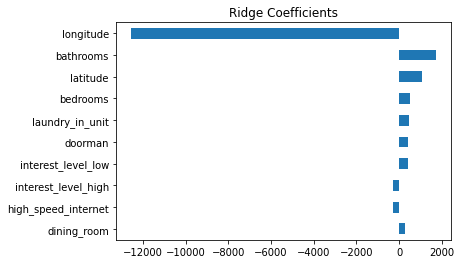

**Note:** Your figure shouldn't be identical to the one above. Your model will have different coefficients since it's been trained on different data. Only the formatting should be the same.

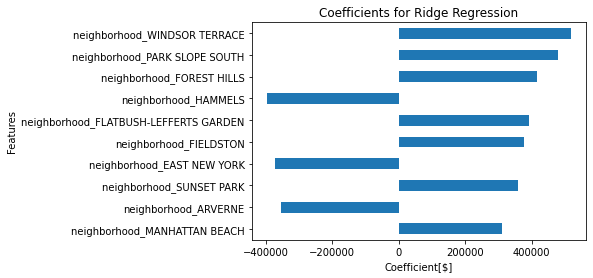

In [30]:
# Plot ridge model
coefficients = model_r.coef_
features = ohe.get_feature_names()

# Create a pd.Series with the coefficients as the data and features as index
feat_imp = pd.Series(coefficients, index=features).sort_values(key=abs)
feat_imp.tail(10).plot(kind = 'barh') #horizontal bar

plt.xlabel('Coefficient[$]')
plt.ylabel('Features')
plt.title('Coefficients for Ridge Regression');

In [31]:
ohe.get_feature_names()

['borough_3',
 'borough_4',
 'borough_2',
 'borough_5',
 'borough_1',
 'neighborhood_OCEAN PARKWAY-NORTH',
 'neighborhood_QUEENS VILLAGE',
 'neighborhood_PELHAM PARKWAY SOUTH',
 'neighborhood_FLATBUSH-CENTRAL',
 'neighborhood_FLATBUSH-EAST',
 'neighborhood_MADISON',
 'neighborhood_MIDWOOD',
 'neighborhood_BAYSIDE',
 'neighborhood_ELMHURST',
 'neighborhood_FLUSHING-NORTH',
 'neighborhood_HOLLIS',
 'neighborhood_HOWARD BEACH',
 'neighborhood_JACKSON HEIGHTS',
 'neighborhood_KEW GARDENS',
 'neighborhood_LAURELTON',
 'neighborhood_SO. JAMAICA-BAISLEY PARK',
 'neighborhood_SOUTH JAMAICA',
 'neighborhood_SPRINGFIELD GARDENS',
 'neighborhood_ELTINGVILLE',
 'neighborhood_GREAT KILLS',
 'neighborhood_MANOR HEIGHTS',
 'neighborhood_WESTERLEIGH',
 'neighborhood_CANARSIE',
 'neighborhood_DYKER HEIGHTS',
 'neighborhood_EAST NEW YORK',
 'neighborhood_GERRITSEN BEACH',
 'neighborhood_OLD MILL BASIN',
 'neighborhood_CAMBRIA HEIGHTS',
 'neighborhood_CORONA',
 'neighborhood_DOUGLASTON',
 'neighborhood_F